<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Summing-abundances-by-sub-network" data-toc-modified-id="Summing-abundances-by-sub-network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summing abundances by sub-network</a></span></li><li><span><a href="#Host-tree-subsample" data-toc-modified-id="Host-tree-subsample-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Host tree subsample</a></span></li><li><span><a href="#PGLS" data-toc-modified-id="PGLS-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>PGLS</a></span></li><li><span><a href="#Diet" data-toc-modified-id="Diet-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Diet</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Saving-output" data-toc-modified-id="Saving-output-8.0.1"><span class="toc-item-num">8.0.1&nbsp;&nbsp;</span>Saving output</a></span></li><li><span><a href="#p-adjust" data-toc-modified-id="p-adjust-8.0.2"><span class="toc-item-num">8.0.2&nbsp;&nbsp;</span>p-adjust</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-8.0.3"><span class="toc-item-num">8.0.3&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Significant-variables" data-toc-modified-id="Significant-variables-8.0.4"><span class="toc-item-num">8.0.4&nbsp;&nbsp;</span>Significant variables</a></span></li></ul></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* PGLS on co-occur sub-network pres/abs in hosts

# Var

In [19]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/PGLS/'

# network
ntwk_file = '/ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur/IndD-sens_OTU-binom_cooccur-ntwk-tbl.txt'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# host phylogeny
host_tree_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_IndD.nwk'

# params
threads = 12
sparsity_cutoff = 0.05

# Init

In [12]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(ape)
library(phyloseq)
library(ade4)
library(ape)
library(caper)

source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 
source('/ebio/abt3_projects/Georg_animal_feces/code/itol.R') 

In [13]:
set.seed(73322)

In [14]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/PGLS/ 


# Load

In [15]:
# phyloseq
physeq = readRDS(physeq_file) %>%
    filter_taxa(function(x) sum(x > 0) / length(x) > sparsity_cutoff, TRUE)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

In [20]:
# network
ntwk = read.delim(ntwk_file, sep='\t')
ntwk %>% dfhead

[1] 129  13


name,Domain,Phylum,Class,Order,Family,Genus,Species,centrality_btw,centrality_hub,centrality_degree,community,d
0206837371f48a70d8103167f4b4204f,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Pseudobutyrivibrio,unclassified,0,0.000000e+00,0.0000000,2,24.267982
0215b7637847641274246f9414d2b649,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,unclassified,14,1.288563e-16,0.1012422,4,4.854486
0852e0ca013fdbd32fa5ab232e102b28,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,unclassified,unclassified,0,0.000000e+00,0.0000000,1,61.035148


In [21]:
# metadata table
metadata = physeq %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(X.SampleID = rownames(.)) %>%
    dplyr::select(X.SampleID, scientific_name, diet, 
                  diet_vertebrate,diet_invertebrate,diet_fruit,
                  diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,
                  diet_seeds,diet_grass_waterplants,diet_roots_tubers) %>%
    mutate(scientific_name = gsub(' ', '_', scientific_name)) %>%
    as.data.frame

rownames(metadata) = metadata$SampleID
metadata %>% dfhead

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213  11


X.SampleID,scientific_name,diet,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers
X1.Eurasian.Beaver,Castor_fiber,herbivore,no,no,no,no,yes,no,yes,yes
X101.Horse,Equus_caballus,herbivore,no,no,no,no,no,yes,yes,no
X102.Kulan,Equus_hemionus,herbivore,no,no,no,no,yes,no,yes,no


In [40]:
# host tree file 
host_tree = read.tree(host_tree_file)
host_tree


Phylogenetic tree with 213 tips and 177 internal nodes.

Tip labels:
	X256.Zander, F302.Northern.Pike, X188.Brook.Trout, F300.Asp, X330.Ide, X327.Silver.Bream, ...
Node labels:
	Node1, Node2, Node3, Node4, Node5, Node6, ...

Rooted; includes branch lengths.

# Summing abundances by sub-network

In [144]:
# # otu table
# otu = physeq %>%
#     otu_table() %>%
#     as.matrix %>%
#     as.data.frame %>%
#     mutate(OTU = rownames(.)) %>%
#     gather(Sample, Count, -OTU) %>%
#     inner_join(ntwk, c('OTU'='name')) %>%
#     group_by(Sample, community) %>%
#     summarize(Count = sum(Count)) %>%
#     ungroup() %>%
#     spread(Sample, Count) %>%
#     as.data.frame

# rownames(otu) = gsub('^', 'SN', otu$community)
# otu$community = NULL
# otu = otu %>% t %>% as.data.frame

# otu = otu[metadata$X.SampleID,]

# otu %>% dfhead

In [118]:
# otu table
## majority pres-abs in network
otu = physeq %>%
    otu_table() %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(OTU = rownames(.)) %>%
    gather(Sample, Count, -OTU) %>%
    mutate(Count = ifelse(Count > 0, 1, 0)) %>%
    inner_join(ntwk, c('OTU'='name')) %>%
    group_by(Sample, community) %>%
    summarize(Pres_perc = sum(Count) / length(Count) * 100,
              Count = ifelse(Pres_perc > 5, 1, 0)) %>%
    ungroup() %>%
    dplyr::select(-Pres_perc) %>%
    spread(Sample, Count) %>%
    as.data.frame

rownames(otu) = gsub('^', 'SN', otu$community)
otu$community = NULL
otu = otu %>% t %>% as.data.frame

otu = otu[metadata$X.SampleID,]

otu %>% dfhead

Warning message:
“Column `OTU`/`name` joining character vector and factor, coercing into character vector”

[1] 213   4


,SN1,SN2,SN3,SN4
X1.Eurasian.Beaver,0,0,0,0
X101.Horse,1,0,0,0
X102.Kulan,1,0,1,0


In [119]:
# summary 
otu %>% rowSums %>% summary
otu %>% colSums %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   1.169   2.000   2.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   45.75   62.00   62.25   78.50   86.00 

In [120]:
diet_vars = c(
'diet',
'diet_vertebrate',
'diet_invertebrate',
'diet_fruit',
'diet_flowers_nectar_pollen',
'diet_leaves_branches_bark_buds',
'diet_seeds',
'diet_grass_waterplants',
'diet_roots_tubers'
)
otu = cbind(metadata[,diet_vars], otu)
otu %>% dfhead

[1] 213  13


,diet,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers,SN1,SN2,SN3,SN4
X1.Eurasian.Beaver,herbivore,no,no,no,no,yes,no,yes,yes,0,0,0,0
X101.Horse,herbivore,no,no,no,no,no,yes,yes,no,1,0,0,0
X102.Kulan,herbivore,no,no,no,no,yes,no,yes,no,1,0,1,0


In [121]:
# transforming
otu$diet = ifelse(otu$diet == 'herbivore', 1,
                  ifelse(otu$diet == 'omnivore', 0.5, 0))

for(x in diet_vars[2:length(diet_vars)]){
    otu[,x] = gsub(' .+', '', otu[,x])
    otu[,x] = ifelse(otu[,x] == 'yes', 1, 0) %>% as.numeric
}

otu$taxa = rownames(otu)
otu %>% dfhead

[1] 213  14


,diet,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers,SN1,SN2,SN3,SN4,taxa
X1.Eurasian.Beaver,1,0,0,0,0,1,0,1,1,0,0,0,0,X1.Eurasian.Beaver
X101.Horse,1,0,0,0,0,0,1,1,0,1,0,0,0,X101.Horse
X102.Kulan,1,0,0,0,0,1,0,1,0,1,0,1,0,X102.Kulan


In [122]:
# checking values
colSums(otu[,1:9])

diet                diet_vertebrate 
                           117                             75 
             diet_invertebrate                     diet_fruit 
                           109                             89 
    diet_flowers_nectar_pollen diet_leaves_branches_bark_buds 
                            18                            101 
                    diet_seeds         diet_grass_waterplants 
                            86                             96 
             diet_roots_tubers 
                            70

# Host tree subsample

In [127]:
setdiff(host_tree$tip.label, rownames(otu)) %>% print
setdiff(rownames(otu), host_tree$tip.label) %>% print

character(0)
character(0)


In [128]:
#' randomly selecting one per group
tree_subsample = function(L, df, tree){
    # get subsample (note: subsampling within each species)
    to_keep = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1) %>%
        .$sample
    # subsampling tree
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    return(tree)
}

In [129]:
# permuted trees
df = metadata %>%
    mutate(sample = X.SampleID) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_l = plyr::llply(as.list(1:100), 
                          function(x) tree_subsample(x, df, host_tree),
                          .parallel=TRUE)
host_tree_l %>% length

[1] 100

In [130]:
# check tips per tree
lapply(host_tree_l, function(x) x$tip.label %>% length) %>% unlist %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    128     128     128     128     128     128 

# PGLS

In [131]:
pgls_each_var = function(y, x, tree, data){
    cdat = comparative.data(data=data, phy=tree, names.col="taxa")
    
    f = as.formula(paste(c(y, x), collapse=' ~ '))
    mod = pgls(f, cdat) %>% summary
    
    df = mod$coefficients %>% as.data.frame
    colnames(df) = c('Estimate', 'std_err', 't_value', 'p_value')
    df$R2 = mod$adj.r.squared %>% as.vector %>% .[1]
    df$x = x
    df$y = y
    df = df[2,] %>% as.data.frame
    return(df)
}

In [132]:
pgls_each_tree = function(rep, y, x, tree_list, data, threads=1){
    tree = tree_list[[rep]]
    data = data[tree$tip.label,] 
    
    doParallel::registerDoParallel(threads)
    ret = plyr::llply(as.list(y),
                      pgls_each_var,
                      x = 'diet',
                      tree = tree,
                      data = data,
                      .parallel = TRUE)
    ret = do.call(rbind, ret)
    ret$rep = rep
    return(ret)
}

# Diet

In [133]:
# running on all OTUs, each permuted tree
y = colnames(otu)[10:(ncol(otu)-1)]     # all sub-networks
ret = plyr::llply(1:length(host_tree_l),
                  pgls_each_tree,
                  y = y,
                  x = 'diet',
                  tree_list = host_tree_l,
                  data = otu,
                  threads = threads)

ret = do.call(rbind, ret) %>%
    as.data.frame
rownames(ret) = 1:nrow(ret)

# status
ret %>% dfhead

[1] 400   8


Estimate,std_err,t_value,p_value,R2,x,y,rep
0.14986460,0.1238393,1.2101536,0.22848534,0.003643930,diet,SN1,1
-0.31057823,0.1804089,-1.7215243,0.08760993,0.015226352,diet,SN2,1
0.02591436,0.2325428,0.1114391,0.91144549,-0.007837175,diet,SN3,1


In [134]:
# formatting results
pgls_res = ret %>%
    mutate(R2 = R2 %>% as.numeric,
           p_value = p_value %>% as.numeric)

pgls_res %>% dfhead

[1] 400   8


Estimate,std_err,t_value,p_value,R2,x,y,rep
0.14986460,0.1238393,1.2101536,0.22848534,0.003643930,diet,SN1,1
-0.31057823,0.1804089,-1.7215243,0.08760993,0.015226352,diet,SN2,1
0.02591436,0.2325428,0.1114391,0.91144549,-0.007837175,diet,SN3,1


### Saving output

In [135]:
# file name
pgls_res_file = file.path(work_dir, 'pgls_IndD_cooccur-ntwk.RDS')
pgls_res_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/PGLS//pgls_IndD_cooccur-ntwk.RDS"

In [136]:
# saving
saveRDS(pgls_res, file=pgls_res_file)
cat('File written:', pgls_res_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/PGLS//pgls_IndD_cooccur-ntwk.RDS 


In [137]:
# re-load 
pgls_res = readRDS(pgls_res_file) 
pgls_res %>% dfhead

[1] 400   8


Estimate,std_err,t_value,p_value,R2,x,y,rep
0.14986460,0.1238393,1.2101536,0.22848534,0.003643930,diet,SN1,1
-0.31057823,0.1804089,-1.7215243,0.08760993,0.015226352,diet,SN2,1
0.02591436,0.2325428,0.1114391,0.91144549,-0.007837175,diet,SN3,1


### p-adjust

In [138]:
# adjusting per subsample rep
pgls_res = pgls_res %>%
    group_by(rep) %>%
    mutate(p_adj_value = p.adjust(p_value, method='BH')) %>%
    ungroup()
pgls_res %>% dfhead

[1] 400   9


Estimate,std_err,t_value,p_value,R2,x,y,rep,p_adj_value
0.14986460,0.1238393,1.2101536,0.22848534,0.003643930,diet,SN1,1,0.4569707
-0.31057823,0.1804089,-1.7215243,0.08760993,0.015226352,diet,SN2,1,0.3504397
0.02591436,0.2325428,0.1114391,0.91144549,-0.007837175,diet,SN3,1,0.9114455


### Plotting

In [139]:
pgls_res %>% summary

    Estimate           std_err          t_value           p_value       
 Min.   :-0.45364   Min.   :0.1204   Min.   :-2.3272   Min.   :0.02155  
 1st Qu.:-0.18262   1st Qu.:0.1741   1st Qu.:-0.8916   1st Qu.:0.30528  
 Median :-0.03622   Median :0.2033   Median :-0.1780   Median :0.47234  
 Mean   :-0.05802   Mean   :0.1953   Mean   :-0.2274   Mean   :0.48778  
 3rd Qu.: 0.10013   3rd Qu.:0.2213   3rd Qu.: 0.5719   3rd Qu.:0.64976  
 Max.   : 0.27654   Max.   :0.2624   Max.   : 1.3661   Max.   :0.99531  
       R2                 x                  y                  rep        
 Min.   :-0.007936   Length:400         Length:400         Min.   :  1.00  
 1st Qu.:-0.006282   Class :character   Class :character   1st Qu.: 25.75  
 Median :-0.003797   Mode  :character   Mode  :character   Median : 50.50  
 Mean   :-0.001324                                         Mean   : 50.50  
 3rd Qu.: 0.000469                                         3rd Qu.: 75.25  
 Max.   : 0.033603               

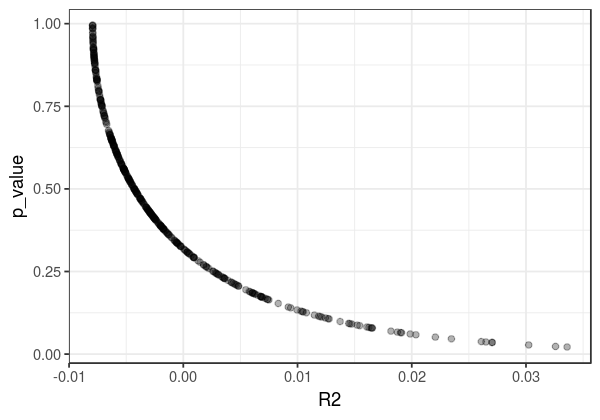

In [140]:
# p-value distribution
p = ggplot(pgls_res, aes(R2, p_value)) +
    geom_point(alpha=0.3) +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3.5)
plot(p)

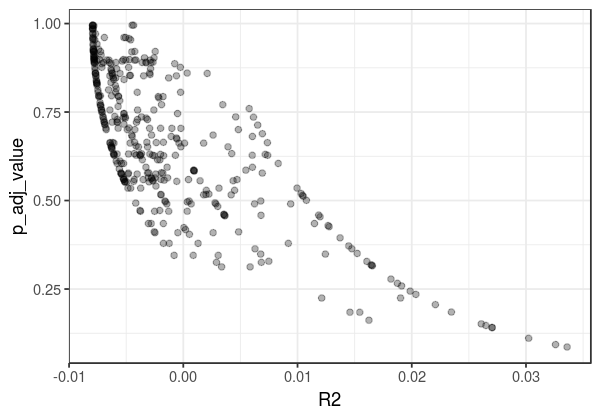

In [141]:
# p-adj-value distribution
p = ggplot(pgls_res, aes(R2, p_adj_value)) +
    geom_point(alpha=0.3) +
    #scale_y_log10() +
    theme_bw() 

options(repr.plot.width=5, repr.plot.height=3.5)
plot(p)

### Significant variables

In [142]:
pgls_res_sig = pgls_res %>%
    group_by(y) %>%
    summarize(
        qvalue = (length(p_adj_value) - sum(p_adj_value < 0.05)) / length(p_adj_value)
        ) %>%
    ungroup() %>%
    filter(qvalue < 0.05)

pgls_res_sig %>% dfhead

[1] 0 2


y,qvalue


# sessionInfo

In [143]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_phylo/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_phylo/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2  caper_1.0.1     mvtnorm_1.0-6   MASS_7.3-50    
 [5] ade4_1.7-11     phyloseq_1.22.3 ape_5.1         ggplot2_3.0.0  
 [9] tidyr_0.8.1     dplyr_0.7.6    

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.17        lattice_0.20-34     Biostrings_2.46.0  
 [4] assertthat_0.2.0    digest_0.6.15       foreach_1.4.4      
 [7] IRdisplay_0.4.4     R6_2.2.2            plyr_1.8.4         
[10] repr_0.15.0         stats4_3.4.1        evaluate_0.10.1    
[13] pillar_1.2.2        zlibbioc_1.24.0     rl